In [34]:
# Extract results

In [35]:
### Imports 
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import time

import pandas as pd

sys.path.append('../../')
from script.conversion.bison.coordinates import rd_to_utm
from mnms.graph.layers import PublicTransportLayer, MultiLayerGraph, OriginDestinationLayer, SharedVehicleLayer
from mnms.generation.roads import generate_pt_line_road, generate_one_zone
from mnms.generation.layers import generate_layer_from_roads
from mnms.vehicles.veh_type import Tram, Metro, Bus, Bike
from mnms.generation.zones import generate_one_zone
from mnms.mobility_service.public_transport import PublicTransportMobilityService
from mnms.mobility_service.vehicle_sharing import VehicleSharingMobilityService
from mnms.time import TimeTable, Dt, Time
from mnms.io.graph import load_graph, save_graph, load_odlayer, save_transit_links
from mnms.tools.render import draw_roads, draw_line, draw_odlayer, draw_path, draw_veh_activity
#from mnms.tools.geometry import points_in_polygon, get_bounding_box

In [36]:
### Parameters

# Files and directories
current_dir = os.getcwd()
indir = current_dir + '/inputs/'
outdir = current_dir + '/outputs/'

#coord_csv_filepath = indir + 'KV1_GVB_2609_2/Csv/POINT.csv' # file with coordinates of the network
#amsterdam_json_filepath = indir + 'new_network.json' # mlgraph with the road network only
amsterdam_json_filepath_pt_transit = indir + "network_pt_transit.json"
transit_path = indir + "transit.json"

# Transit connection (m)
DIST_MAX = 500
DIST_CONNECTION_OD = 200
DIST_CONNECTION_PT = 100
DIST_CONNECTION_MIX = 100

In [37]:
### Load network

mmgraph_pt = load_graph(indir + "network_pt_short.json")
# odlayer = load_odlayer(indir + "od_layer_clustered_200.json")
df_emoped1 = pd.read_csv(indir + 'init_pos_emoped.csv')
df_emoped2 = pd.read_csv(indir + 'init_pos_emoped.csv')

### Load demand

df_dmd = pd.read_csv(indir + 'custom_demand.csv', sep=";")

In [38]:
## Load results

df_emoped1 = pd.read_csv(outdir+'emoped1.csv', sep=";")
df_path = pd.read_csv(outdir+'path.csv', sep=";")

In [45]:
# Look vehicle trajectory
veh_id = 47
df = df_emoped1[df_emoped1["ID"] == int(veh_id)]

In [46]:
# Look O/D for users wihtout paths
list_nomatch = []
list_origins = []
list_destinations = []
for i, row in df_path[:].iterrows():
    if pd.isna(row['PATH']):
        list_nomatch.append(row['ID'])
        user = df_dmd[df_dmd['ID']==row['ID']]
        list_origins.append([float(o) for o in user['ORIGIN'].iloc[0].split(' ')])
        list_destinations.append([float(o) for o in user['DESTINATION'].iloc[0].split(' ')])

In [47]:
df_dmd

,ID,DEPARTURE,ORIGIN,DESTINATION
0,1013696-1,07:00:11,629891.5501061575 5807764.308142089,629206.7485171846 5802718.428188983
1,1041202-1,07:00:15,626515.7810087365 5804857.124552886,627880.7645051661 5801620.341258972
2,1082035-1,07:02:13,626783.0014626541 5802019.078548846,627521.5991698907 5802139.395577453
3,1036317-2,07:03:09,626733.1728912272 5802692.911896407,626796.1714493468 5803249.104904612
4,1039609-1,07:03:33,626657.4039649597 5802667.380458823,625904.7375438417 5801304.4185826555
...,...,...,...,...
178,1086906-1,08:58:15,628687.7257023167 5801084.169195911,629113.4636707206 5801401.171718666
179,1008430-1,08:58:43,631217.0634915064 5807018.895249622,629472.3143697395 5803759.93006108
180,1060582-1,08:59:00,627953.680650466 5806399.10925086,629771.0274529499 5801512.188125436
181,1040867-1,08:59:07,626595.303046123 5802680.543638766,625192.4512876405 5801536.0953376135


In [48]:
polygon = np.asarray([
    [628000, 5.81e6],
    [632500, 5.808e6],
    [634000, 5.8055e6],
    [634000, 5.803e6],
    [633000, 5.801e6],
    [630500, 5.7995e6],
    [629000, 5.8e6],
    [625500, 5.8e6],
    [625500, 5.803e6],
    [625500, 5.806e6]
])

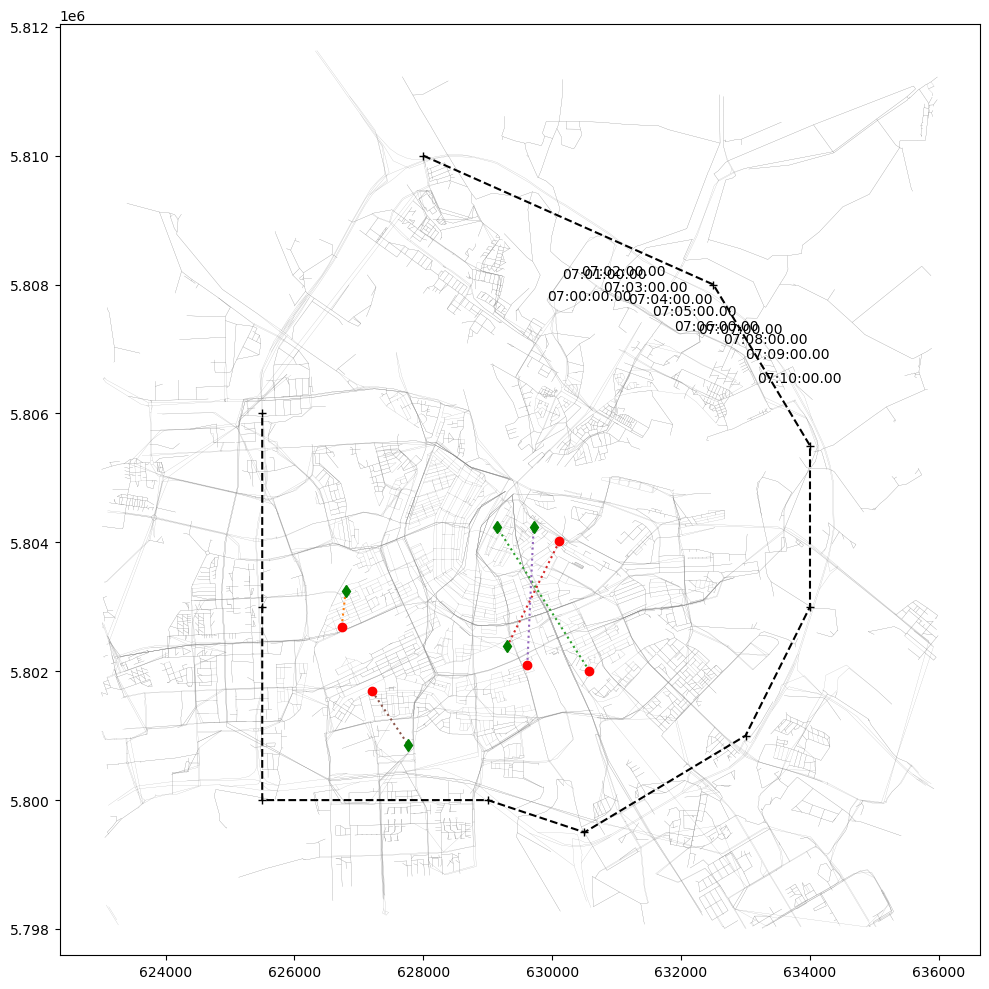

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)
for i, row in df.iterrows():
    pos = row['POSITION'].split(' ')
    plt.text(float(pos[0]), float(pos[1]), row.TIME)

for o,d in zip(list_origins, list_destinations):
    plt.plot([o[0], d[0]], [o[1], d[1]], ':')
    plt.plot(d[0], d[1], 'dg')
    plt.plot(o[0], o[1], 'or')

plt.plot(polygon[:,0], polygon[:,1], '+--k')

In [44]:
len(mmgraph_pt.roads.sections)

23249